# Import and Mount Google Drive
This section is to import all the different libraries for the sections bellow.


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

import PIL.Image as Image
from IPython.display import Image, display
import matplotlib.cm as cm

Connect Google Drive 

In [19]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Create Datasets

In [20]:
data_dir = os.path.join(os.curdir, '/content/gdrive/My Drive/ML2/Exam_Project/Dataset')
                        
BATCH_SIZE = 32
IMG_SIZE = (192, 192)

train_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=999,
                                                            validation_split=0.20,
                                                            subset = "training")

validation_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=999,
                                                            validation_split=0.20,
                                                            subset = "validation")

Found 1933 files belonging to 2 classes.
Using 1547 files for training.
Found 1933 files belonging to 2 classes.
Using 386 files for validation.


In [21]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Datasets for xception model

In [23]:
data_dir = '/content/gdrive/My Drive/ML2/Exam_Project/Dataset'

BATCH_SIZE = 32
IMG_SIZE = (150, 150)

train_dataset_xception = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=999,
                                                            validation_split=0.20,
                                                            subset = "training")

validation_dataset_xception = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=999,
                                                            validation_split=0.20,
                                                            subset = "validation")

Found 1933 files belonging to 2 classes.
Using 1547 files for training.
Found 1933 files belonging to 2 classes.
Using 386 files for validation.


In [24]:
val_batches = tf.data.experimental.cardinality(validation_dataset_xception)
test_dataset_xception = validation_dataset_xception.take(val_batches // 5)
validation_dataset_xception = validation_dataset_xception.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset_xception))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset_xception))

Number of validation batches: 11
Number of test batches: 2


In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset_xception = train_dataset_xception.prefetch(buffer_size=AUTOTUNE)
validation_dataset_xception = validation_dataset_xception.prefetch(buffer_size=AUTOTUNE)
test_dataset_xception = test_dataset_xception.prefetch(buffer_size=AUTOTUNE)

# Fine Tuning

As we seen in the evaluation, the basemodel MobileNetV2 performes better than the Xception Model. Therefore we try to reach an even better performance with finetuning this model

In [26]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (192, 192)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

Load the saved model for fine tuning

In [27]:
path_saved_model_MobileNetV2 = '/content/gdrive/My Drive/ML2/Exam_Project/saved_model/classify_ai_real_images_MobileNetV2'

pretrained_model_mobileNetV2 = tf.keras.models.load_model(path_saved_model_MobileNetV2)
# Check its architecture
pretrained_model_mobileNetV2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 192, 192, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 192, 192, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 192, 192, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_192 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                             

set the base model to trainable that we can change the wheigts

In [28]:
base_model.trainable = True

set the layer from which the finetuning shoul start. All other layers disabled for training

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [30]:
base_learning_rate = 0.0001
pretrained_model_mobileNetV2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [31]:
pretrained_model_mobileNetV2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 192, 192, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 192, 192, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 192, 192, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_192 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                             

Train the model with 10 finetuning epochs and see what we can achieve with that.

In [32]:
initial_epochs = 50 
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = pretrained_model_mobileNetV2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=50,
                         validation_data=validation_dataset)

Epoch 51/60
49/49 [==============================] - 17s 234ms/step - loss: 0.3325 - accuracy: 0.8184 - val_loss: 0.2450 - val_accuracy: 0.9348
Epoch 52/60
49/49 [==============================] - 11s 204ms/step - loss: 0.3220 - accuracy: 0.8235 - val_loss: 0.2489 - val_accuracy: 0.9348
Epoch 53/60
49/49 [==============================] - 10s 187ms/step - loss: 0.3313 - accuracy: 0.8248 - val_loss: 0.2640 - val_accuracy: 0.9130
Epoch 54/60
49/49 [==============================] - 11s 198ms/step - loss: 0.3132 - accuracy: 0.8274 - val_loss: 0.2679 - val_accuracy: 0.9130
Epoch 55/60
49/49 [==============================] - 11s 192ms/step - loss: 0.3273 - accuracy: 0.8339 - val_loss: 0.2618 - val_accuracy: 0.9224
Epoch 56/60
49/49 [==============================] - 11s 203ms/step - loss: 0.3266 - accuracy: 0.8132 - val_loss: 0.2551 - val_accuracy: 0.9286
Epoch 57/60
49/49 [==============================] - 11s 209ms/step - loss: 0.3256 - accuracy: 0.8177 - val_loss: 0.2656 - val_accuracy:

In [33]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

As we can see in the plot the finetuning isn't improving the model. 
My guess here is, that it is not possible to reach a better accuracy because the generated images are partially verry real. 

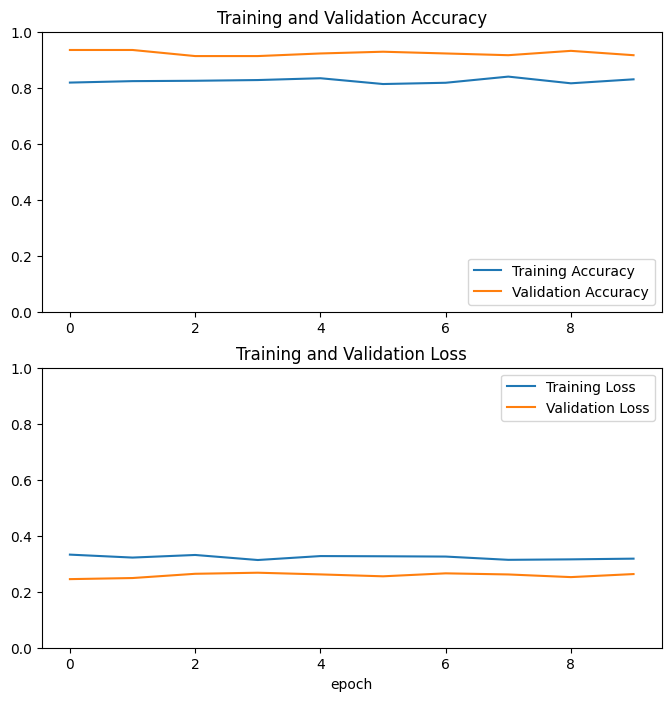

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [40]:
# Evaluate the restored model
loss, acc = pretrained_model_mobileNetV2.evaluate(validation_dataset)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(pretrained_model_mobileNetV2.predict(validation_dataset).shape)

11/11 [==============================] - 2s 149ms/step - loss: 0.2613 - accuracy: 0.9255
Restored model, accuracy: 92.55%
11/11 [==============================] - 3s 146ms/step
(322, 1)


In [41]:
# Evaluate the restored model
loss, acc = pretrained_model_mobileNetV2.evaluate(test_dataset)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(pretrained_model_mobileNetV2.predict(test_dataset).shape)

2/2 [==============================] - 1s 179ms/step - loss: 0.2761 - accuracy: 0.9062
Restored model, accuracy: 90.62%
2/2 [==============================] - 1s 191ms/step
(64, 1)


In [39]:
path_saved_model = '/content/gdrive/My Drive/ML2/Exam_Project/saved_model/classify_ai_real_images_MobileNetV2_finetuned'

pretrained_model_mobileNetV2.save(path_saved_model)